# Introduction

L'objectif de ce projet est de créer un modèle de reconnaissance des chiffres manuscrits.  
Nous allons donc tester différentes méthodes de classification sur le fameux jeu de données MNIST qui contient des images labélisées de chiffres manuscrits.

# Préparation de l'environnement

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

# scikit-learn
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

# Préparation du jeu de données

Commençons par importer le jeu de données MNIST.

In [2]:
dataset = tf.keras.datasets.mnist.load_data(path="mnist.npz")
data, labels = dataset[0]
img_size = data[0].shape
data = data.reshape(data.shape[0], -1)
(n_samples, n_features) = data.shape

print(f"Nombre d'observations (images): {n_samples}.")
print(f"Taille de chaque observations (Nombre de pixels dans chaque image): {n_features}.")


Nombre d'observations (images): 60000.
Taille de chaque observations (Nombre de pixels dans chaque image): 784.


Dans un premier temps, nous nous limiterons à utiliser 2000 images du jeu de données afin de comparer les différents modèles. 

Une fois nous avons décidé lequel des modèles faut garder, nous allons le réentrainer avec le jeu de données complet.

In [3]:
# Use only 2000 pictures
data = data[:2000,:]
labels = labels[:2000]

Voyons à quoi ressemble notre dataset.

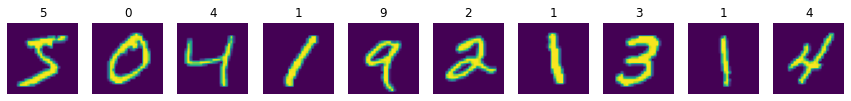

In [4]:
fig = plt.figure(figsize = (15,15))
for idx in range(10):
    ax = plt.subplot(1,10, idx+1)
    ax.imshow(data[idx].reshape(int(np.sqrt(n_features)), -1))
    ax.set_title(labels[idx])
    ax.axis("off")
plt.show()

Divisons le jeu de données en deux sous-ensembles, l'un pour l'entrainement et l'autre pour la validation.

Remarque : au lieu de faire une division aléatoire (train_test_split), il faut forcer une bonne division du jeu de données pour que le modèle s'entraine sur tous les cas possibles. Une division aléatoire n'est pas la bonne approche dans ce cas, car elle peut entrainer la disparition d'une classe du jeu de données d'entrainement.

Exemple : Un jeu de données d'entrainement qui ne contient aucune image du chiffre zero, car toutes ces images sont dans le jeu de données de validation (même si la probabilité d'un tel evenement est faible, elle reste quand même non nul !).

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in sss.split(data, labels):
   X_train, X_test = data[train_index], data[test_index]
   y_train, y_test = labels[train_index], labels[test_index]

print(f"On a donc {len(X_train)} images d'entrainement et {len(X_test)} images de test.")

On a donc 1800 images d'entrainement et 200 images de test.


# Modèles De Classification

Dans cette partie, nous allons tester et comparer plusieurs méthodes de classification

## K Plus Proches Voisins (K Nearest Neighbors)

Faisons une première implémentation avec k (nombre de voisins) = 5

In [6]:
# Create the model
knn = KNeighborsClassifier(n_neighbors=5)
# Train the model
knn.fit(X_train, y_train)
# Compute the model's score
score = knn.score(X_test, y_test)

print(f"La précision du modèle est : {score * 100:.2f}%")

La précision du modèle est : 92.50%


Dans la cellule au-dessus, nous avons implémenté le modèle avec le paramètre k = 5 sans raison particulière.  

dans la suite nous allons déterminer le meilleur paramètre k pour optimiser la performance du modèle. 

In [7]:
# Create a new knn model
knn = KNeighborsClassifier()
# Create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 20)}
# Use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
# Fit model to data
knn_gscv.fit(X_train, y_train)
# Best parameter k (n_neighbors)
best_k = knn_gscv.best_params_['n_neighbors']
print(f"Le meilleur paramètre à utiliser est k (n_neighbors) = {best_k}")
# Create knn model with best parameter k = best_k
knn = KNeighborsClassifier(n_neighbors= int(best_k))
# Fit the model
knn.fit(X_train, y_train)
# Compute the score
score = knn.score(X_test, y_test)

print(f"La nouvelle précision du modèle est : {score * 100:.2f}%")

Le meilleur paramètre à utiliser est k (n_neighbors) = 1
La nouvelle précision du modèle est : 94.00%


Effectivement, la précision du modèle a augmenté.

## Machine A Support De Vecteur (SVM)

Puisque les images sont de petite taille, alors une machine à support de vecteur pourra être une bonne approche pour répondre à notre besoin.

Remarque: les SVMs sont très sensibles à la normalisation, donc il faut bien normaliser le jeu de données avant d'entrainer le modèle.

In [8]:
# The actual size of the images can be reduced with a pca
# Otherwise the SVM model would take quite some time to run
# Note : Using the pca we don't lose much information, specially
# In this case since we forced it to keep at least 90% of the information
pca = PCA()
pca.fit(X_train)
n_components = np.argwhere(np.cumsum(pca.explained_variance_ratio_) > 0.90)[0][0]

print(f"Le nombre de composantes à conserver pour avoir une approximation à 90% est : {n_components}")

Le nombre de composantes à conserver pour avoir une approximation à 90% est : 80


In [9]:
# We need to apply PCA and normalization each
# time we want to train our model, or use it 
# to predict. 
# That is why it is more practicale to combine
# these actions in a pipeline.
svm_clf = Pipeline(
    [
        ('pca', PCA(n_components)),
        ('scaler', StandardScaler()),
        ('linear_svm', LinearSVC(C=1, dual = False, max_iter=50000))
    ]
)

# Fit the model
svm_clf.fit(X_train, y_train)
# Compute the score
score = svm_clf.score(X_test, y_test)
# Print the result
print(f"La précision du modèle est : {score * 100:.2f}%")

La précision du modèle est : 88.50%


## Arbres De Décision (Decision Trees)

Implémentons un arbre de classification.

In [10]:
# Create the decision tree
tree_clf = tree.DecisionTreeClassifier()
# Train the decision tree
tree_clf.fit(X_train, y_train)
# Compute the score
score = tree_clf.score(X_test, y_test)
# Print the score
print(f"La précision du modèle est : {score * 100:.2f}%")

La précision du modèle est : 74.50%


## Reseau De Neurons (Neural network)

La première chose à faire est de choisir l'architecture et de créer le modèle correspondant.

Je vais utilisé une architecture reduite du Xception qui est une très bonne architecture pour les problèmes de classification d'images.

Remarque : Actuellement, la meilleur architecture (state of the art) pour faire de la classification d'images est le <b>Vision Transformer (ViT)</b>, donc si votre projet sera déployé en production vaut mieux utiliser cette architecture (ViT) plutôt que la mienne (En tout cas, ça depend de la précision exigé par votre cahier des charges). 

Moi j'ai décidé d'utiliser une architecture reduite du Xception afin de reduire le temps d'excution de mon programme (je travaille sur mon ordinateur personnelle).

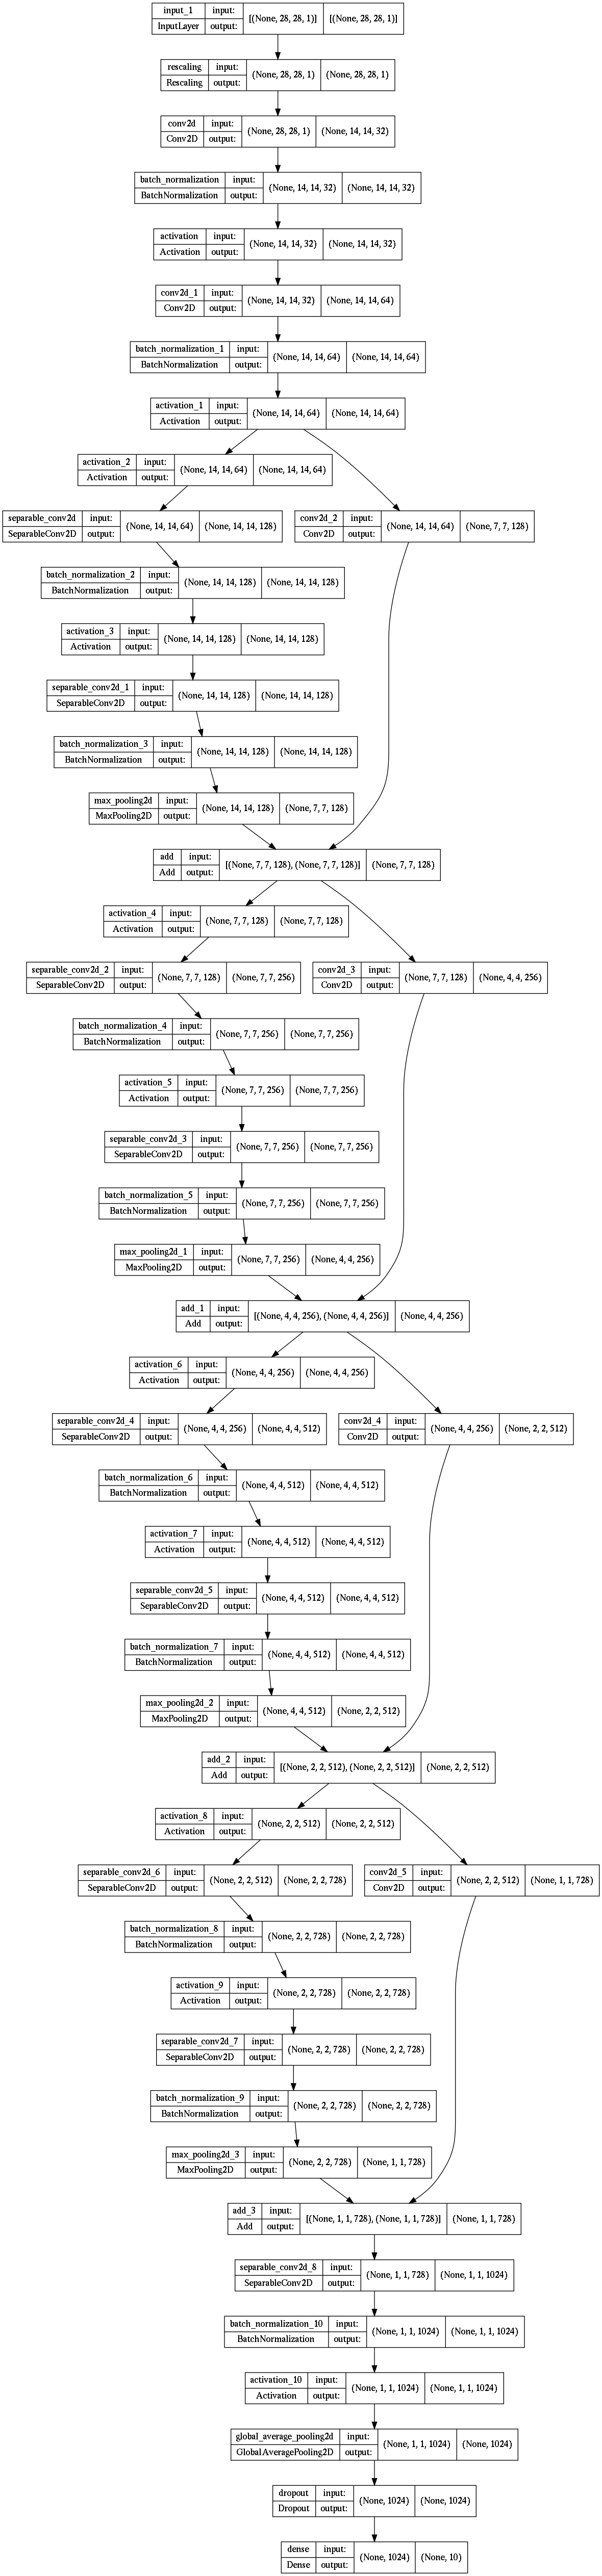

In [11]:
def createModel(input_shape, num_classes):
    """
    Create the deep learning model using a reduced
    Xception architecture. 

    Arguments : 
    -----------
    input_shape : {tuple of size 3} the input shape of the model.
    num_classes : {integer} the number of classes to predict.

    Returns : 
    ---------
    This function returns the model object {tf.keras.Model}
    """
    input = tf.keras.layers.Input(shape=input_shape)

    # Entry block
    x = tf.keras.layers.Rescaling(1.0 / 255)(input)
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(input, outputs)

model = createModel(input_shape= img_size + (1,), num_classes= 10)
tf.keras.utils.plot_model(model, show_shapes= True)


In [12]:
# Prepare the data 
ohe = OneHotEncoder(sparse = False)
ohe.fit(y_train.reshape(-1,1))

X_train = X_train.reshape((X_train.shape[0], int(np.sqrt(n_features)), -1))
y_train = ohe.transform(y_train.reshape(-1,1))

X_test = X_test.reshape(X_test.shape[0], int(np.sqrt(n_features)), -1)
y_test = ohe.transform(y_test.reshape(-1,1))

In [13]:
# Compile the model
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4), loss = "categorical_crossentropy", metrics=["accuracy"])

In [14]:
# Train the model
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 20)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5",monitor= "val_accuracy", mode = "max",save_best_only=True)
model.fit(X_train, y_train, validation_split= 0.2 ,epochs= 100, callbacks= [earlyStopping, modelCheckpoint], verbose= 0)

Calculons la précision du reseau de neurons.

In [15]:
model = tf.keras.models.load_model("./best_model.h5")
loss, accuracy = tuple(model.evaluate(X_test, y_test, verbose=0))
print(f"La précision est : {accuracy * 100:.2f}%")

La précision est : 98.00%


On tire les conclusions suivantes : 

* Les arbres de décision ne sont pas convenables pour ce problème.
* Le modèle des k plus proches voisins et la machine à support de vecteur ont une bonne précision.
* Le modèle de reseau de neurons est celui qui donne la meilleur précision, donc c'est lui qu'on utilisera par la suite.

Remarque : 
* Si on avait des images de grandes dimensions, le k plus proches voisins aurait rencontré le fameux <b><u>fléau de la dimension</u></b> et donc sa précision aurait été affaiblie.


# Entrainement Et Prédiction :

Commençons par importer le jeu de données complet.

In [16]:
# Import full dataset
dataset = tf.keras.datasets.mnist.load_data(path="mnist.npz")
data, labels = dataset[0]
img_size = data[0].shape
data = data.reshape(data.shape[0], -1)
(n_samples, n_features) = data.shape

print(f"Nombre d'observations (images): {n_samples}.")
print(f"Taille de chaque observations (Nombre de pixels dans chaque image): {n_features}.")

# Divid the dataset into train and test sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in sss.split(data, labels):
   X_train, X_test = data[train_index], data[test_index]
   y_train, y_test = labels[train_index], labels[test_index]

print(f"On a donc {len(X_train)} images d'entrainement et {len(X_test)} images de test.")

# Prepare the data 
ohe = OneHotEncoder(sparse = False)
ohe.fit(y_train.reshape(-1,1))

X_train = X_train.reshape((X_train.shape[0], int(np.sqrt(n_features)), -1))
y_train = ohe.transform(y_train.reshape(-1,1))

X_test = X_test.reshape(X_test.shape[0], int(np.sqrt(n_features)), -1)
y_test = ohe.transform(y_test.reshape(-1,1))

Nombre d'observations (images): 60000.
Taille de chaque observations (Nombre de pixels dans chaque image): 784.
On a donc 54000 images d'entrainement et 6000 images de test.


Créer et entrainer le modèle

In [17]:
# Create model
model = createModel(input_shape= img_size + (1,), num_classes= 10)

# Compile the model
model.compile(optimizer= tf.keras.optimizers.Adam(1e-4), loss = "categorical_crossentropy", metrics=["accuracy"])

# Train the model
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 20)
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5",monitor= "val_accuracy", mode = "max",save_best_only=True)
model.fit(X_train, y_train, validation_split= 0.2 ,epochs= 100, callbacks= [earlyStopping, modelCheckpoint], verbose= 0)

Calculons la précision du modèle de reseau de neurons entrainé sur le jeu de données complet.

In [18]:
model = tf.keras.models.load_model("./best_model.h5")
loss, accuracy = tuple(model.evaluate(X_test, y_test, verbose=0))
print(f"La précision du modèle entrainé sur le dataset complet est : {accuracy * 100:.2f}%")

La précision du modèle entrainé sur le dataset complet est : 98.98%


Extraordinaire, nous avons réussi à atteindre une précision de presque 99% sur le jeu de données test.

Voici quelques exemples de prédictions;

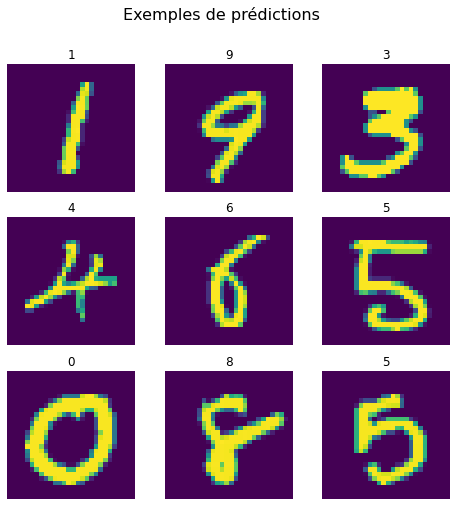

In [19]:
fig = plt.figure(figsize = (8,8))
for idx in range(9):
    ax = plt.subplot(3,3, idx+1)
    ax.imshow(X_test[idx])
    prediction = ohe.inverse_transform(model.predict(np.array([X_test[idx]])))[0][0]
    ax.set_title(str(prediction))
    ax.axis("off")
fig.suptitle('Exemples de prédictions', fontsize=16)
plt.show()